<h1 align="center"> Image Captioning</h1>

In this notebook you will teach a network to do image captioning.
![img](https://i.imgur.com/obITaMl.png)



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

Cost of this notebook is **15 points**.

In [1]:
# Please either download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually with preprocess_data.ipynb

### Data preprocessing

In [2]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 174 ms, sys: 429 ms, total: 604 ms
Wall time: 603 ms


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [3]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [4]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [15]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

# Compute word frequencies for each word in captions. See code above for data structure
for caption in captions:
    for sent in caption:
        for word in sent:
            word_counts[word] += 1

In [16]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [18]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [19]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [20]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [21]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(
            num_embeddings=n_tokens,
            embedding_dim=emb_size
        )
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(
            input_size=emb_size,
            hidden_size=lstm_units,
            batch_first=True,
        )
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(in_features=lstm_units, out_features=n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, (hidden, cell) = self.lstm(captions_emb, (initial_cell[None], initial_hid[None]))
        
        # compute logits from lstm_out
        logits = self.logits(lstm_out)
        
        return logits        

In [82]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
network = CaptionNet(n_tokens)
network.to(device)

CaptionNet(
  (cnn_to_h0): Linear(in_features=2048, out_features=256, bias=True)
  (cnn_to_c0): Linear(in_features=2048, out_features=256, bias=True)
  (emb): Embedding(10403, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (logits): Linear(in_features=256, out_features=10403, bias=True)
)

In [83]:
device

device(type='cuda')

In [85]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec.to(device), dummy_capt_ix.to(device))

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [86]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
#     logp_for_next = F.log_softmax(logits_for_next, dim=-1)
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
#     print(logits_for_next.view(-1).shape, captions_ix_next.view(-1).shape)

    criterion = nn.CrossEntropyLoss(ignore_index=pad_ix)
    loss = criterion(logits_for_next.view(-1, logits_for_next.shape[-1]),
                     captions_ix_next.view(-1))
    
    return loss

In [88]:
dummy_loss = compute_loss(network, dummy_img_vec.to(device), dummy_capt_ix.to(device))

assert dummy_loss.shape == torch.Size([]), 'loss must be scalar'
assert dummy_loss.cpu().data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

Create ~~adam~~ your favorite optimizer for the network.

In [89]:
opt = torch.optim.Adam(network.parameters())

# Training

* First implement the batch generator
* Than train the network as usual

In [90]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [95]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32).to(device), torch.tensor(batch_captions_ix, dtype=torch.int64).to(device)
    

In [96]:
generate_batch(img_codes,captions,3)

(tensor([[0.0479, 0.2284, 0.5462,  ..., 0.1611, 0.6831, 0.1785],
         [0.1978, 0.6852, 0.6091,  ..., 0.0970, 0.8347, 0.0803],
         [0.8820, 0.1015, 0.5468,  ..., 0.3125, 0.2699, 0.1187]],
        device='cuda:0'),
 tensor([[   1,   24,   57,   35,   24,   80,  497,   50,  210,   44,  164, 4780,
            12,    2,    3,    3],
         [   1,   24,   57,  140,  193,  117,   24,  160,   15,   47,   48,   35,
            24,  157,   12,    2],
         [   1,   88,    4, 1215,   35,   24,  154,   58,   24,   48,   35,   24,
           749,    2,    3,    3]], device='cuda:0'))

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [97]:
batch_size = 50  # adjust me
n_epochs = 100  # adjust me
n_batches_per_epoch = 50  # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch

In [98]:
from tqdm import tqdm

for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        opt.zero_grad()
        loss_t.backward()
        opt.step()
        
        train_loss += loss_t.item()
        
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.item()
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

 20%|██        | 10/50 [00:00<00:00, 97.13it/s]


Epoch: 0, train loss: 6.021415643692016, val loss: 4.914901256561279


 20%|██        | 10/50 [00:00<00:00, 92.03it/s]


Epoch: 1, train loss: 4.744527254104614, val loss: 4.673175621032715


 20%|██        | 10/50 [00:00<00:00, 90.97it/s]


Epoch: 2, train loss: 4.411316537857056, val loss: 4.398008346557617


 20%|██        | 10/50 [00:00<00:00, 93.93it/s]


Epoch: 3, train loss: 4.242919774055481, val loss: 4.131854391098022


 20%|██        | 10/50 [00:00<00:00, 95.59it/s]


Epoch: 4, train loss: 4.120926241874695, val loss: 4.021928215026856


 20%|██        | 10/50 [00:00<00:00, 95.35it/s]


Epoch: 5, train loss: 4.0005175447463985, val loss: 3.9974722862243652


 20%|██        | 10/50 [00:00<00:00, 99.26it/s]


Epoch: 6, train loss: 3.921385631561279, val loss: 3.970580244064331


 20%|██        | 10/50 [00:00<00:00, 91.25it/s]


Epoch: 7, train loss: 3.8156542873382566, val loss: 3.769086217880249


 20%|██        | 10/50 [00:00<00:00, 95.49it/s]


Epoch: 8, train loss: 3.7505280637741087, val loss: 3.7173068046569826


 20%|██        | 10/50 [00:00<00:00, 97.00it/s]


Epoch: 9, train loss: 3.6912742042541504, val loss: 3.703216218948364


 20%|██        | 10/50 [00:00<00:00, 99.54it/s]


Epoch: 10, train loss: 3.6380528926849367, val loss: 3.629612398147583


 18%|█▊        | 9/50 [00:00<00:00, 85.17it/s]


Epoch: 11, train loss: 3.5622231435775755, val loss: 3.6259300231933596


 20%|██        | 10/50 [00:00<00:00, 95.81it/s]


Epoch: 12, train loss: 3.5057941579818728, val loss: 3.4154617309570314


 20%|██        | 10/50 [00:00<00:00, 98.46it/s]


Epoch: 13, train loss: 3.4943862915039063, val loss: 3.354669189453125


 20%|██        | 10/50 [00:00<00:00, 91.92it/s]


Epoch: 14, train loss: 3.4569947576522826, val loss: 3.462577724456787


 22%|██▏       | 11/50 [00:00<00:00, 101.79it/s]


Epoch: 15, train loss: 3.3739002323150635, val loss: 3.371834468841553


 20%|██        | 10/50 [00:00<00:00, 98.19it/s]


Epoch: 16, train loss: 3.3748604440689087, val loss: 3.3556954860687256


 20%|██        | 10/50 [00:00<00:00, 98.94it/s]


Epoch: 17, train loss: 3.353393135070801, val loss: 3.2413293361663817


 20%|██        | 10/50 [00:00<00:00, 94.25it/s]


Epoch: 18, train loss: 3.305301809310913, val loss: 3.1834671974182127


 20%|██        | 10/50 [00:00<00:00, 91.53it/s]


Epoch: 19, train loss: 3.2924827337265015, val loss: 3.3392717361450197


 20%|██        | 10/50 [00:00<00:00, 94.14it/s]


Epoch: 20, train loss: 3.2061013174057007, val loss: 3.297554111480713


 20%|██        | 10/50 [00:00<00:00, 99.05it/s]


Epoch: 21, train loss: 3.2048869037628176, val loss: 3.2746397972106935


 20%|██        | 10/50 [00:00<00:00, 97.54it/s]


Epoch: 22, train loss: 3.2268123197555543, val loss: 3.0065556526184083


 20%|██        | 10/50 [00:00<00:00, 95.62it/s]


Epoch: 23, train loss: 3.111724853515625, val loss: 3.050709676742554


 22%|██▏       | 11/50 [00:00<00:00, 100.24it/s]


Epoch: 24, train loss: 3.1273617696762086, val loss: 3.2397937297821047


 20%|██        | 10/50 [00:00<00:00, 96.95it/s]


Epoch: 25, train loss: 3.1692596673965454, val loss: 3.1268879890441896


 22%|██▏       | 11/50 [00:00<00:00, 98.80it/s]


Epoch: 26, train loss: 3.1149398422241212, val loss: 2.9679454803466796


 20%|██        | 10/50 [00:00<00:00, 95.44it/s]


Epoch: 27, train loss: 3.0931606101989746, val loss: 2.9811136722564697


 20%|██        | 10/50 [00:00<00:00, 97.44it/s]


Epoch: 28, train loss: 3.0842198514938355, val loss: 3.1423728466033936


 20%|██        | 10/50 [00:00<00:00, 99.53it/s]


Epoch: 29, train loss: 3.072458019256592, val loss: 3.1322508811950684


 20%|██        | 10/50 [00:00<00:00, 98.30it/s]


Epoch: 30, train loss: 3.0430781698226927, val loss: 3.0284306526184084


 18%|█▊        | 9/50 [00:00<00:00, 82.21it/s]


Epoch: 31, train loss: 3.0522989320755003, val loss: 3.083182764053345


 20%|██        | 10/50 [00:00<00:00, 91.90it/s]


Epoch: 32, train loss: 3.0209970045089722, val loss: 3.0903491497039797


 22%|██▏       | 11/50 [00:00<00:00, 102.80it/s]


Epoch: 33, train loss: 3.0056049013137818, val loss: 3.009633779525757


 22%|██▏       | 11/50 [00:00<00:00, 100.97it/s]


Epoch: 34, train loss: 2.962301244735718, val loss: 2.971672010421753


 20%|██        | 10/50 [00:00<00:00, 94.51it/s]


Epoch: 35, train loss: 2.9611049270629883, val loss: 2.9499489307403564


 20%|██        | 10/50 [00:00<00:00, 98.13it/s]


Epoch: 36, train loss: 3.028636112213135, val loss: 2.8927961349487306


 20%|██        | 10/50 [00:00<00:00, 98.46it/s]


Epoch: 37, train loss: 2.956004276275635, val loss: 2.9829490184783936


 20%|██        | 10/50 [00:00<00:00, 98.37it/s]


Epoch: 38, train loss: 2.931968550682068, val loss: 2.983793258666992


 18%|█▊        | 9/50 [00:00<00:00, 85.69it/s]


Epoch: 39, train loss: 2.956152081489563, val loss: 2.9464890480041506


 22%|██▏       | 11/50 [00:00<00:00, 92.42it/s]


Epoch: 40, train loss: 2.9380209112167357, val loss: 2.8070894718170165


 20%|██        | 10/50 [00:00<00:00, 89.63it/s]


Epoch: 41, train loss: 2.9353752374649047, val loss: 2.8593970775604247


 20%|██        | 10/50 [00:00<00:00, 94.19it/s]


Epoch: 42, train loss: 2.8692174625396727, val loss: 2.934669303894043


 20%|██        | 10/50 [00:00<00:00, 99.08it/s]


Epoch: 43, train loss: 2.895626969337463, val loss: 2.9808969020843508


 20%|██        | 10/50 [00:00<00:00, 92.85it/s]


Epoch: 44, train loss: 2.8729352140426636, val loss: 2.851822853088379


 20%|██        | 10/50 [00:00<00:00, 99.75it/s]


Epoch: 45, train loss: 2.88497341632843, val loss: 2.896262693405151


 22%|██▏       | 11/50 [00:00<00:00, 102.23it/s]


Epoch: 46, train loss: 2.900571413040161, val loss: 2.8446793079376222


 20%|██        | 10/50 [00:00<00:00, 94.13it/s]


Epoch: 47, train loss: 2.842127170562744, val loss: 2.9772279262542725


 18%|█▊        | 9/50 [00:00<00:00, 76.33it/s]


Epoch: 48, train loss: 2.862949686050415, val loss: 2.952035140991211


 20%|██        | 10/50 [00:00<00:00, 95.17it/s]


Epoch: 49, train loss: 2.8775527811050416, val loss: 2.901815128326416


 20%|██        | 10/50 [00:00<00:00, 97.36it/s]


Epoch: 50, train loss: 2.8258413171768186, val loss: 2.859203052520752


 18%|█▊        | 9/50 [00:00<00:00, 90.00it/s]


Epoch: 51, train loss: 2.8251840114593505, val loss: 2.8796167373657227


 18%|█▊        | 9/50 [00:00<00:00, 82.66it/s]


Epoch: 52, train loss: 2.8660161685943604, val loss: 2.8467525959014894


 18%|█▊        | 9/50 [00:00<00:00, 86.66it/s]


Epoch: 53, train loss: 2.8544041872024537, val loss: 2.8671889305114746


 20%|██        | 10/50 [00:00<00:00, 94.72it/s]


Epoch: 54, train loss: 2.808569703102112, val loss: 2.745071029663086


 20%|██        | 10/50 [00:00<00:00, 91.82it/s]


Epoch: 55, train loss: 2.824425292015076, val loss: 2.771667957305908


 18%|█▊        | 9/50 [00:00<00:00, 84.84it/s]


Epoch: 56, train loss: 2.772176532745361, val loss: 2.83371901512146


 18%|█▊        | 9/50 [00:00<00:00, 89.43it/s]


Epoch: 57, train loss: 2.7779477548599245, val loss: 2.7889617919921874


 20%|██        | 10/50 [00:00<00:00, 94.68it/s]


Epoch: 58, train loss: 2.781377983093262, val loss: 2.8170474052429197


 20%|██        | 10/50 [00:00<00:00, 97.06it/s]


Epoch: 59, train loss: 2.792980456352234, val loss: 2.7291537284851075


 20%|██        | 10/50 [00:00<00:00, 94.26it/s]


Epoch: 60, train loss: 2.7220340871810915, val loss: 2.8792882442474363


 18%|█▊        | 9/50 [00:00<00:00, 84.31it/s]


Epoch: 61, train loss: 2.7470830965042112, val loss: 2.7642872810363768


 20%|██        | 10/50 [00:00<00:00, 95.75it/s]


Epoch: 62, train loss: 2.7403429889678956, val loss: 2.7933971881866455


 18%|█▊        | 9/50 [00:00<00:00, 88.19it/s]


Epoch: 63, train loss: 2.7569760704040527, val loss: 2.7928643226623535


 20%|██        | 10/50 [00:00<00:00, 95.05it/s]


Epoch: 64, train loss: 2.7276708602905275, val loss: 2.9073392868041994


 20%|██        | 10/50 [00:00<00:00, 98.89it/s]


Epoch: 65, train loss: 2.723511829376221, val loss: 2.712056064605713


 20%|██        | 10/50 [00:00<00:00, 96.03it/s]


Epoch: 66, train loss: 2.718668417930603, val loss: 2.8518519401550293


 20%|██        | 10/50 [00:00<00:00, 95.66it/s]


Epoch: 67, train loss: 2.7345401191711427, val loss: 2.826487493515015


 18%|█▊        | 9/50 [00:00<00:00, 84.72it/s]


Epoch: 68, train loss: 2.75790557384491, val loss: 2.8225584506988524


 18%|█▊        | 9/50 [00:00<00:00, 84.50it/s]


Epoch: 69, train loss: 2.7197628736495973, val loss: 2.8070170879364014


 20%|██        | 10/50 [00:00<00:00, 91.64it/s]


Epoch: 70, train loss: 2.7346721506118774, val loss: 2.623407554626465


 18%|█▊        | 9/50 [00:00<00:00, 88.00it/s]


Epoch: 71, train loss: 2.735699372291565, val loss: 2.804837131500244


 20%|██        | 10/50 [00:00<00:00, 94.15it/s]


Epoch: 72, train loss: 2.6865254783630372, val loss: 2.851576232910156


 22%|██▏       | 11/50 [00:00<00:00, 100.10it/s]


Epoch: 73, train loss: 2.7424451160430907, val loss: 2.63360481262207


 18%|█▊        | 9/50 [00:00<00:00, 86.87it/s]


Epoch: 74, train loss: 2.69462769985199, val loss: 2.710089015960693


 18%|█▊        | 9/50 [00:00<00:00, 82.90it/s]


Epoch: 75, train loss: 2.710157585144043, val loss: 2.670663356781006


 20%|██        | 10/50 [00:00<00:00, 98.44it/s]


Epoch: 76, train loss: 2.706278910636902, val loss: 2.7513301372528076


 20%|██        | 10/50 [00:00<00:00, 88.20it/s]


Epoch: 77, train loss: 2.6944209909439087, val loss: 2.7292885303497316


 18%|█▊        | 9/50 [00:00<00:00, 85.72it/s]


Epoch: 78, train loss: 2.6606336641311645, val loss: 2.7207075119018556


 18%|█▊        | 9/50 [00:00<00:00, 83.05it/s]


Epoch: 79, train loss: 2.721811580657959, val loss: 2.7219241142272947


 20%|██        | 10/50 [00:00<00:00, 96.41it/s]


Epoch: 80, train loss: 2.7091183185577394, val loss: 2.712750720977783


 20%|██        | 10/50 [00:00<00:00, 98.66it/s]


Epoch: 81, train loss: 2.687467484474182, val loss: 2.6020694255828856


 18%|█▊        | 9/50 [00:00<00:00, 87.21it/s]


Epoch: 82, train loss: 2.686504988670349, val loss: 2.8464991569519045


 20%|██        | 10/50 [00:00<00:00, 96.88it/s]


Epoch: 83, train loss: 2.6817050647735594, val loss: 2.7551455020904543


 18%|█▊        | 9/50 [00:00<00:00, 89.21it/s]


Epoch: 84, train loss: 2.625996346473694, val loss: 2.744841957092285


 20%|██        | 10/50 [00:00<00:00, 89.18it/s]


Epoch: 85, train loss: 2.6354631423950194, val loss: 2.4773353576660155


 20%|██        | 10/50 [00:00<00:00, 93.37it/s]


Epoch: 86, train loss: 2.6589620685577393, val loss: 2.6603214263916017


 20%|██        | 10/50 [00:00<00:00, 93.71it/s]


Epoch: 87, train loss: 2.657412428855896, val loss: 2.650576877593994


 20%|██        | 10/50 [00:00<00:00, 99.73it/s]


Epoch: 88, train loss: 2.6678046655654906, val loss: 2.818464994430542


 20%|██        | 10/50 [00:00<00:00, 97.42it/s]


Epoch: 89, train loss: 2.681994571685791, val loss: 2.73285174369812


 18%|█▊        | 9/50 [00:00<00:00, 86.72it/s]


Epoch: 90, train loss: 2.6274630498886107, val loss: 2.648788833618164


 20%|██        | 10/50 [00:00<00:00, 91.69it/s]


Epoch: 91, train loss: 2.6271900939941406, val loss: 2.6439011096954346


 20%|██        | 10/50 [00:00<00:00, 93.58it/s]


Epoch: 92, train loss: 2.6736791801452635, val loss: 2.5697014808654783


 20%|██        | 10/50 [00:00<00:00, 96.68it/s]


Epoch: 93, train loss: 2.657156271934509, val loss: 2.572420597076416


 18%|█▊        | 9/50 [00:00<00:00, 82.04it/s]


Epoch: 94, train loss: 2.6478538274765016, val loss: 2.6419493198394775


 20%|██        | 10/50 [00:00<00:00, 97.52it/s]


Epoch: 95, train loss: 2.6450063228607177, val loss: 2.6019084453582764


 20%|██        | 10/50 [00:00<00:00, 94.90it/s]


Epoch: 96, train loss: 2.6277698421478273, val loss: 2.6474204540252684


 20%|██        | 10/50 [00:00<00:00, 95.89it/s]


Epoch: 97, train loss: 2.6000171947479247, val loss: 2.6648914337158205


 18%|█▊        | 9/50 [00:00<00:00, 87.95it/s]


Epoch: 98, train loss: 2.646170334815979, val loss: 2.591279411315918


100%|██████████| 50/50 [00:00<00:00, 89.39it/s]


Epoch: 99, train loss: 2.6375076246261595, val loss: 2.6123711109161376
Finished!


### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [99]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [104]:
network.cpu()

CaptionNet(
  (cnn_to_h0): Linear(in_features=2048, out_features=256, bias=True)
  (cnn_to_c0): Linear(in_features=2048, out_features=256, bias=True)
  (emb): Embedding(10403, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (logits): Linear(in_features=256, out_features=10403, bias=True)
)

In [100]:
def generate_caption(image, caption_prefix=("#START#",), 
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break
            
    return caption_prefix

In [101]:
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

--2021-06-26 13:45:39--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.84.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.84.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2021-06-26 13:45:39--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.86.217
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.86.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  53.45K  --.-KB/s    in 0.003s  

2021-06-26 13:45:39 (15.4 MB/s) - ‘data/img.jpg’ saved [54731/54731]



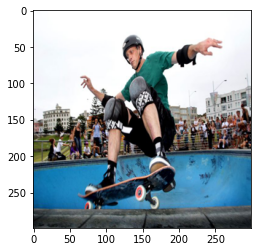

In [102]:
plt.imshow(img)

In [105]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man is doing a trick on a skateboard .
a man is doing a trick on a skateboard .
a man is doing a trick on a skateboard .
a man on a skateboard doing a trick .
a man is doing a trick on a skateboard .
a man is doing a trick on a skateboard .
a man is doing a trick on a skateboard .
a man is doing a trick on a skateboard .
a man is doing a trick on a skateboard .
a man is doing a trick on a skateboard .


--2021-06-26 13:48:36--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 104.239.249.248
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2021-06-26 13:48:37--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 104.37K   331KB/s    in 0.3s    

2021-06-26 13:48:37 (331 KB/s) - ‘data/img.jpg’ saved [106870/106870]



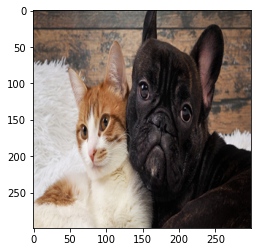

a cat is laying on a couch in a room .
a cat laying on a bed with a black cat on it .
a cat sitting on a wooden floor next to a window .
a cat that is sitting on a chair .
a cat sitting on a couch next to a book .
a cat is sitting on a chair next to a white wall .
a cat laying on a bed with a cat .
a cat laying on a bed with a cat in the background .
a cat is standing in a room with a cat .
a cat is laying down on a couch


In [106]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo
### Find at least 10 images to test it on.

* Seriously, that's a part of the assignment. Go get at least 10 pictures for captioning
* Make sure it works okay on __simple__ images before going to something more complex
* Your pictures must feature both successful and failed captioning. Get creative :)
* Use photos, not animation/3d/drawings, unless you want to re-train CNN network on anime
* Mind the aspect ratio.

In [108]:
def get_caption_for_img(url):
    !wget -q $url -O data/img.jpg
    
    img = plt.imread('data/img.jpg')
    img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.
    
    plt.imshow(img)
    plt.show()
    
    for i in range(10):
        print(' '.join(generate_caption(img, t=5.)[1:-1]))

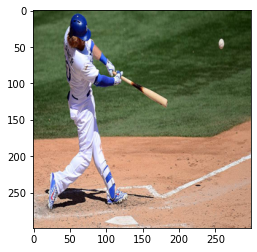

a baseball player swinging a bat at a ball .
a baseball player swinging a bat at a baseball .
a baseball player swinging a bat at a baseball game .
a baseball player is swinging a bat at a ball .
a baseball player swinging a bat at a ball .
a baseball player swinging a bat at a baseball game .
a baseball player swinging a bat at a ball .
a baseball player swinging a bat at a ball .
a baseball player holding a bat on a field .
a baseball player swinging a bat at a ball .


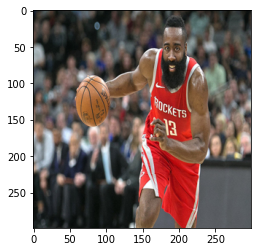

a man holding a baseball bat on a field .
a man holding a baseball bat in a field .
a man holding a baseball bat on a field .
a man holding a baseball bat on a field .
a man holding a baseball bat on a field .
a man holding a bat and a baseball player .
a man holding a bat in his hand
a man holding a baseball bat on a field .
a man holding a baseball bat in a field .
a man holding a baseball bat in a field .


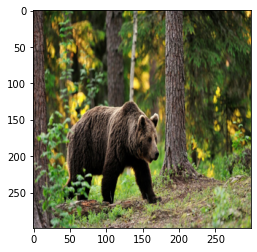

a bear is standing in the grass near a tree .
a bear is standing in the middle of a field .
a bear is walking across a lush green field .
a bear is standing in the grass near trees .
a bear is standing in the grass near a tree .
a bear is standing in the grass near a tree .
a bear is standing in the grass near a fence .
a bear is standing in the grass next to a tree .
a bear in a field with a tree in the background
a bear is standing in the grass near a tree .


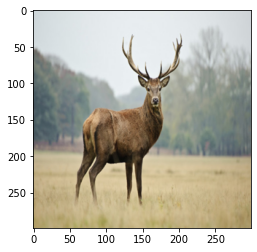

a white and black and white photo of a man in a field
a white and black and white photo of a man in a field .
a white and black and white photo of a man in a field
a white and black and white cow in a field
a white and black and white image of a man standing in a field .
a large white and black and white cow standing in a field
a white and black and white photo of a man in a field .
a white and black and white photo of a man in a field
a white and black and white cow standing in a field .
a white and black and white photo of a man in a field .


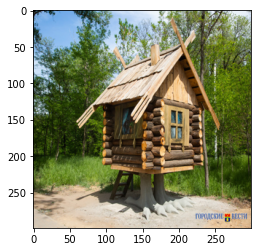

a large red fire hydrant sitting on a tree .
a red fire hydrant sitting on a tree .
a fire hydrant on a park bench in a park .
a large tree sitting on a lush green field .
a large tree is sitting on a bench .
a large tree sitting on a tree in a park .
a small tree with a tree in the background .
a large red fire hydrant on a cloudy day .
a large red fire hydrant sitting on a tree .
a large tree is parked on a tree .


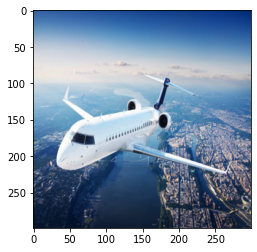

a large jetliner sitting on top of a runway .
a large jetliner sitting on top of a runway .
a large plane flying through the air
a large jetliner flying through the air while a plane flies overhead .
a large jetliner flying over a bridge in the air .
a large jetliner flying through the air while a plane flies .
a large jetliner flying through the air while a man is on a cloudy day .
a plane is parked on the runway at the airport .
a plane is parked on the runway at the airport .
a large jetliner flying through the air while a man is on the runway .


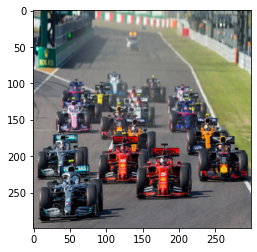

a group of people standing around a bus stop .
a city street with people and cars and cars
a city street with a lot of cars and a street sign .
a group of people standing around a bus in a city .
a city street with a lot of people on it .
a group of people standing around a bus stop .
a city street with lots of cars and buildings .
a city street with a lot of cars and cars parked in the background .
a city street with a lot of cars and cars .
a busy city street with people and cars in the background .


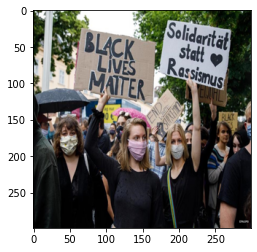

a woman with a red shirt and a woman sitting on a table .
a group of people are standing around a table .
a woman and a woman are sitting at a table .
a woman and a woman are sitting on a table .
a woman and a woman are sitting on a table .
a group of people standing around a table with a bottle of wine .
a woman holding a cell phone in front of a car .
a woman holding a cell phone in front of a car .
a couple of people are standing around a table .
a woman holding a cell phone with a woman in a red shirt and a hat .


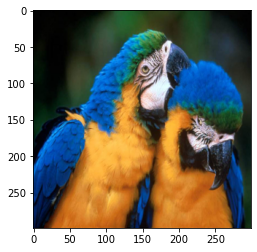

a couple of people sitting on a wooden table .
a bird that is sitting on a tree .
a group of people standing around a table .
a small bird sitting on a wooden table .
a couple of birds sitting on top of a tree .
a small bird sitting on a wooden table
a couple of birds sitting on top of a wooden table .
a red and white bird sitting on a wooden table .
a bird sitting on a wooden table .
a white and black bird sitting on a wooden table .


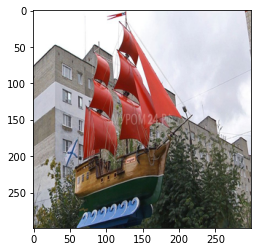

a large clock tower in a large building .
a large clock tower with a clock on the side of it
a large clock tower with a clock on the side of it .
a clock tower with a clock on the side of the side of the building .
a large clock tower with a clock on the side of it
a large clock tower with a clock on the side of a building .
a large clock tower with a clock on the side of it
a large clock tower with a clock on the side of it .
a large clock tower with a clock on the side of it
a large clock tower with a clock on the side of it


In [133]:
# apply your network on images you've found

images = [
    'https://im.kommersant.ru/Issues.photo/CORP/2015/04/06/KMO_088197_194964_1_t218_112322.jpg',
    'https://s-cdn.sportbox.ru/images/styles/800_800_auto/fp_fotos/22/e7/264ef3e1e6955168f8a8bc1de7dbbcae5b703b7350470611393905.jpg',
    'https://avatars.mds.yandex.net/get-zen_doc/927575/pub_5d21346c6f1b6800b68fcc4b_5d21346e399af200ad5bb9de/scale_1200',
    'https://static7.depositphotos.com/1072187/762/i/600/depositphotos_7629722-stock-photo-portrait-of-majestic-red-deer.jpg',
    'http://gorvesti.ru/files/2018/63253-1181021-13209-1y2gyxy.jpg',
    'https://st.depositphotos.com/1002489/4136/i/600/depositphotos_41367457-stock-photo-private-jet-plane-in-the.jpg',
    'https://motor.ru/imgs/2020/06/12/09/3953559/fafa60a0f587cf498f51dcb482253714be2a0a98.jpg',
    'https://kor.ill.in.ua/m/1260x900/2510116.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/4/42/%D0%A1%D0%B8%D0%BD%D0%B5-%D0%B6%D1%91%D0%BB%D1%82%D1%8B%D0%B9_%D0%B0%D1%80%D0%B0_%28Ara_ararauna%29.jpg',
    'http://муром24.рф/uploads/posts/2016-09/1472728456_00113.mts.still013.jpg',
]
for url in images:
    get_caption_for_img(url)


In [ ]:
#
#

Good hunting!
![img](https://cs7.pikabu.ru/images/big_size_comm_an/2018-09_3/1536865148163644198.gif)